### Torus Geometry
- **Triangular unit cell**: Primitive vectors |G₁|=|G₂| with 120 degree in between
- **Landau level**: n = 0 (lowest Landau level)
- **Brillouin zone area**: 2π/l² = √0.75 × G²
- **Magnetic length**: l = √(ℏ/eB) sets the length scale

### Bilayer Parameters
- **Nc_conserved = 2**: Number of layers (components)
- **Inter-layer distance**: d/l
- **Tunneling amplitude**: t/W0 = 0.0
- **Displacement field**: ΔE/W0, energy difference between layers

### Interaction Details
- **Layer conservation**: Interactions preserve layer index of each particle
- **Layer symmetric**: Interactions unchanged if swap the two layer indices
- **Gate Screening**: D/l
- **Different-layer interaction**: Includes e^{-ql*d/l} attenuation factor
- **Form factor**: See arXiv.2509.07784 Eq.(A28) 

In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED
include("../Landau level triangular.jl")
using .LLT

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(subtitle=nothing)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        #xlabel = "momentum block number",
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(subspaces)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ax_top.xticks = top_ticks
    if subtitle isa String
        ax_top.subtitle = subtitle
    end
    display(fig)
end

plot_ed_spectrum (generic function with 2 methods)

In [2]:
#

# Define k-mesh for bilayer system (4×3 mesh, Nk=12) in triangular lattice
k_list = [0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2]
Nk = 12
Gk = (4, 3)  # Grid dimensions


# number of electrons in each layer
Ne1 = 3
Ne2 = 3

# Number of layers (components) for bilayer system
Nc_conserve = 2

#

2

In [3]:
# Define k-mesh for bilayer system (4×4 mesh, Nk=16) in triangular lattice

#=
k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]
Nk = 16
Gk = (4, 4)  # Grid dimensions

# number of electrons in each layer
Ne1 = 4
Ne2 = 4

# Number of layers (components) for bilayer system
Nc_conserve = 2
=#

In [4]:
ΔE = 0 * LLT.W0                # Energy difference between the two layers

# Set up one-body Hamiltonian matrix for inter-layer tunneling
# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, Nk=6
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
# Add energy difference terms: ΔE = 0.5 * W0 between different layers
# No tunneling
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [5]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 0.1                  # Inter-layer distance d/l
# compute the pseudo-potential components
intra_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
inter_PP = LLT.pseudo_potential_decomposition.(0:15; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane pseudo-potential
# sys_int.V_intra = [0.0; 0.8; 0.0; 0.4]          # Intralayer Haldane pseudo-potential in unit of W0
# sys_int.V_inter = [1.5; 0.7; 0.5; 0.4]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
sys_int.V_intra = copy(intra_PP)
sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para_conserve = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.6347066215405632, 0.7493532823751158, 0.5286565941067407, 0.41872505368204593, 0.3503224973226579, 0.3026782860863603, 0.2671381550406759, 0.2393751098165452, 0.21695533203249928, 0.19839158716928695, 0.18271725829183577, 0.16927336306332738, 0.15759318809374134, 0.1473357319489056, 0.13824529565043234, 0.13012589008205516]
inter_PP = [1.538982326541291, 0.7473021108429173, 0.5281101963919731, 0.4184538927733024, 0.35015484524301843, 0.3025623702653088, 0.26705238102427886, 0.2393086769107607, 0.21690216474877644, 0.19834797338980364, 0.1826807859849803, 0.1692423884973554, 0.15756654773338755, 0.14731257622096056, 0.13822498800698133, 0.13010794307028978]


In [6]:
# Create momentum blocks for bilayer system
subspaces, ss_k1, ss_k2 = 
    ED_momentum_subspaces(para_conserve, (Ne1, Ne2));
display(length.(subspaces))

# Generate Scatter lists for efficient Hamiltonian construction
scat_list1_conserve = ED_sortedScatterList_onebody(para_conserve);
scat_list2_conserve = ED_sortedScatterList_twobody(para_conserve);

# construct the Hamiltonian operator
hmlt = MBOperator(scat_list2_conserve, scat_list1_conserve; upper_hermitian = true)

12-element Vector{Int64}:
 4036
 4032
 4032
 4036
 4032
 4032
 4036
 4032
 4032
 4036
 4032
 4032

Many Body Operator (upper_hermitian=true) :
	Vector{MomentumED.Scatter{2}} with 1368 scattering terms


In [7]:
Neigen = 10  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector{}}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing block #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], hmlt;
        N = Neigen, showtime = true, ishermitian = true
    )
end

Processing block #1 with size 4036, momentum 0, 0
  0.832554 seconds (601.44 k allocations: 72.023 MiB, 8.29% gc time, 77.23% compilation time)
  3.747280 seconds (5.42 M allocations: 327.194 MiB, 2.60% gc time, 94.07% compilation time)
Processing block #2 with size 4032, momentum 0, 1
  0.600270 seconds (186 allocations: 41.168 MiB, 79.21% gc time)
  0.225152 seconds (5.93 k allocations: 61.068 MiB)
Processing block #3 with size 4032, momentum 0, 2
  0.137426 seconds (144 allocations: 41.165 MiB, 15.48% gc time)
  0.240048 seconds (6.13 k allocations: 62.937 MiB)
Processing block #4 with size 4036, momentum 1, 0
  0.159062 seconds (189 allocations: 41.243 MiB, 8.73% gc time)
  0.479677 seconds (8.03 k allocations: 81.928 MiB, 1.31% gc time)
Processing block #5 with size 4032, momentum 1, 1
  0.209265 seconds (187 allocations: 41.169 MiB, 3.28% gc time)
  0.333303 seconds (5.57 k allocations: 57.460 MiB, 4.28% gc time)
Processing block #6 with size 4032, momentum 1, 2
  0.206104 second

In [8]:
Neigen = 10  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector{}}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing block #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat_list2_conserve, scat_list1_conserve;
        N = Neigen, showtime = true, ishermitian = true
    )
end

Processing block #1 with size 4036, momentum 0, 0
  0.233222 seconds (160.99 k allocations: 49.498 MiB, 66.59% compilation time)
  0.239980 seconds (5.93 k allocations: 61.127 MiB, 9.49% gc time)
Processing block #2 with size 4032, momentum 0, 1
  0.091812 seconds (4.18 k allocations: 41.289 MiB, 18.28% gc time)
  0.227759 seconds (5.93 k allocations: 61.068 MiB, 1.57% gc time)
Processing block #3 with size 4032, momentum 0, 2
  0.071577 seconds (4.18 k allocations: 41.289 MiB, 4.25% gc time)
  0.211950 seconds (5.93 k allocations: 61.068 MiB, 1.84% gc time)
Processing block #4 with size 4036, momentum 1, 0
  0.075067 seconds (4.19 k allocations: 41.364 MiB, 4.41% gc time)
  0.257321 seconds (7.49 k allocations: 76.082 MiB, 2.76% gc time)
Processing block #5 with size 4032, momentum 1, 1
  0.057032 seconds (4.18 k allocations: 41.289 MiB, 4.85% gc time)
  0.307739 seconds (5.56 k allocations: 57.459 MiB, 20.97% gc time)
Processing block #6 with size 4032, momentum 1, 2
  0.538882 secon

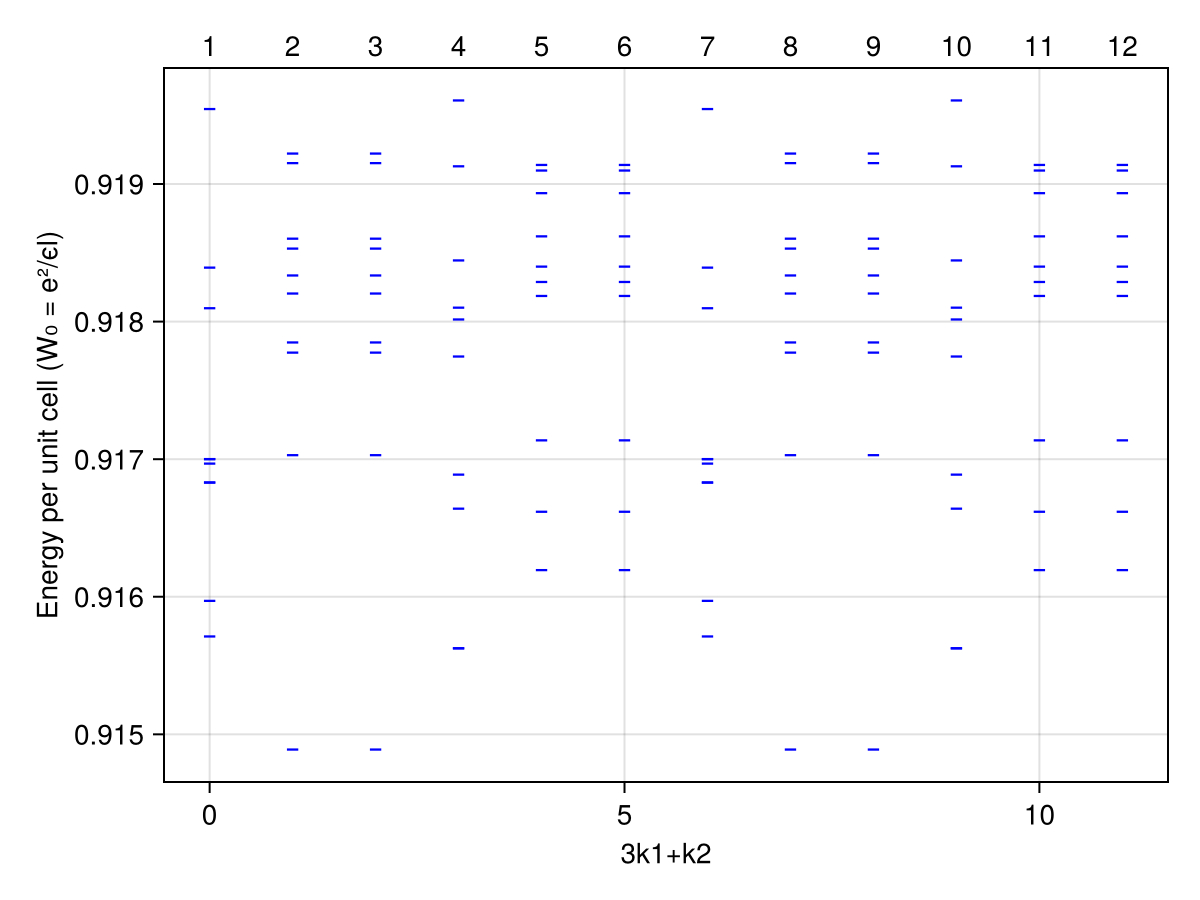

In [7]:
plot_ed_spectrum();

In [7]:
# check energies explicitly to see degeneracy.
bn = 2 # the block number to inspect
println("total momentum: ", ss_k1[bn], "  ", ss_k2[bn])
energies[bn]/Nk/LLT.W0

total momentum: 0  1


10-element Vector{Float64}:
 0.9148894831364226
 0.9170290863272442
 0.9177744638507638
 0.917848273710693
 0.9182039731319082
 0.9183351997867125
 0.9185304486358352
 0.9186026324752069
 0.9191516924634179
 0.9192212841915443

Compute and plot one-body reduced density matrix

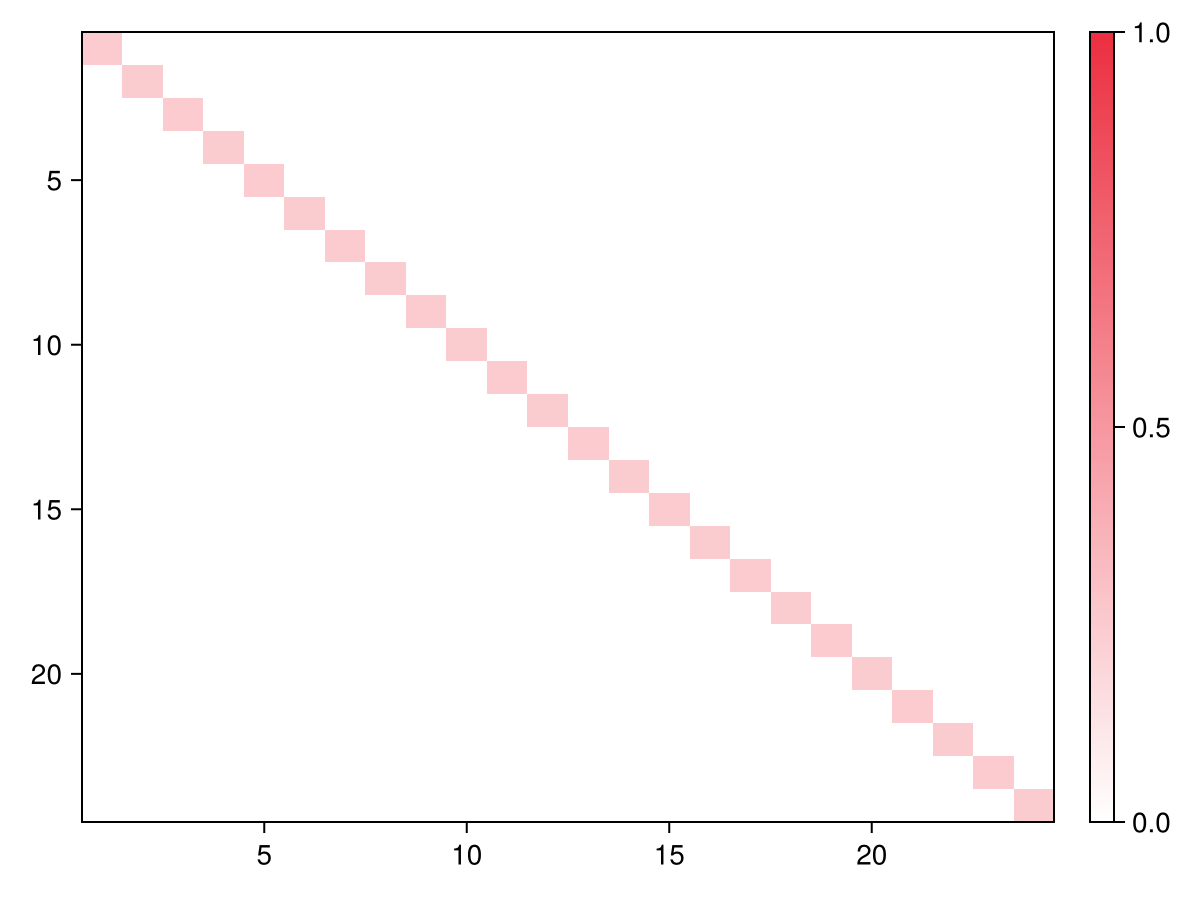

In [8]:
# plot the reduced density matrix of the ground eigenstate in the first block
rdm = ED_onebody_rdm(vectors[bn][1])

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [8]:
# twist angle path for the Wilson loop integral
N_shift = 5  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.2, 0.0)
 (0.2, 0.2)
 (0.0, 0.2)
 (0.0, 0.0)

In [9]:
bn = 2                     # block number
nstates = 1                # number of degenerating states

psi_before = vectors[bn][1:nstates]
ED_connection_gaugefixing!(psi_before)            # fix global phase
psi_after = [similar(psi_before[1]) for _ in eachindex(psi_before)]

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    # scat_list1 = ED_sortedScatterList_onebody(para_conserve; kshift = path[i+1]);
    scat_list2 = ED_sortedScatterList_twobody(para_conserve; kshift = path[i+1]);
    psi_after = EDsolve(subspaces[bn], scat_list2; N = 6,
        showtime = false,
    )[2][1:nstates]
    ED_connection_gaugefixing!(psi_after)          # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step( 
        psi_after, psi_before, path[i+1], path[i], para_conserve;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

ab = 

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


ComplexF64[-0.00880721615654227 - 0.006589137960520311im;;]
-0.00880721615654227 - 0.006589137960520311im
path point #1 	 (0.2, 0.0)
ComplexF64[0.010847028116912433 + 0.0018236711659934742im;;]
0.010847028116912433 + 0.0018236711659934742im
Inner product: amp = 1.0000000000000009, phase = -0.05235987755981541
path point #2 	 (0.2, 0.2)
ComplexF64[-0.01067946981661581 - 0.002633005872911017im;;]
-0.01067946981661581 - 0.002633005872911017im
Inner product: amp = 0.9999999999999982, phase = 0.2722713633112193
path point #3 	 (0.0, 0.2)
ComplexF64[0.010228184049078538 + 0.0040457442515449095im;;]
0.010228184049078538 + 0.0040457442515449095im
Inner product: amp = 0.9999999999999992, phase = 0.1151917306315409
path point #4 	 (0.0, 0.0)
ComplexF64[0.007665499617300001 + 0.007888213429409575im;;]
0.007665499617300001 + 0.007888213429409575im
Inner product: amp = 1.0000000000000038, phase = -0.2094395102394854


0.4999999999994736